# Optimisation: Using Transformed Parameters

This example shows you how to run a global optimisation with a transformed parameter space.

For a more elaborate example of an optimisation, see: [basic optimisation example](./first-example.ipynb).

First we will create a toy model which implements the logistic model.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl
import math

model = toy.LogisticModel()

The parameters for the toy logistic model are $[r, K]$, where $r$ is the rate and $K$ is the carrying capacity. We will create a wrapper pints model that assumes that the parameters are given as $(r, \log(K)]$

In [2]:
class TransformedModel(pints.ForwardModel):
    def __init__(self, model):
        self._model = model
    def n_parameters(self):
        return self._model.n_parameters()
    def simulate(self, parameters, times):
        transformed_parameters = [parameters[0], math.exp(parameters[1])]
        return self._model.simulate(transformed_parameters,times)

transformed_model = TransformedModel(model)

Now that we have our transformed model, we can use it in combination with all of pints' optimisation and inference algorithms. For now, we will use it to fit simulated data using CMA-ES:

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      3.47e+07   0:00.1
1     12     3.46e+07   0:00.1
2     18     3.4e+07    0:00.1
3     24     3.39e+07   0:00.1
20    126    4077706    0:00.1
40    246    358305.2   0:00.2
60    366    95402.77   0:00.2
80    486    95402.77   0:00.2
100   606    95402.77   0:00.3
120   726    95402.77   0:00.3
140   846    95402.77   0:00.4
160   966    95402.77   0:00.4
180   1086   95402.77   0:00.4
200   1206   92522.28   0:00.5
220   1326   92519.12   0:00.5
240   1446   92519.12   0:00.6
260   1566   92519.12   0:00.6
280   1686   92519.12   0:00.6
300   1806   92519.12   0:00.7
320   1926   92519.12   0:00.7
340   2046   92519.12   0:00.7
360   2166   92519.12   0:00.8
380   2286   92519.12   0:00.8
400   2406   92519.12   0:00.9
420   2526   92519.12   0:00.9
440   2646   92519.12   0:01.0
460   2766   92519.12   0:01

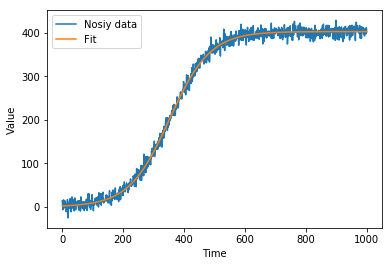

In [3]:
# Create some toy data
real_parameters = [0.015, 6]
times = np.linspace(0, 1000, 1000)
values = transformed_model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(transformed_model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, -6.0], [0.03, 20.0])

# Perform an optimization with boundaries and hints
x0 = 0.01,5.0
sigma0 = [0.01, 2.0]
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    boundaries,
    method=pints.CMAES,
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
pl.figure()
pl.xlabel('Time')
pl.ylabel('Value')
pl.plot(times, values, label='Nosiy data')
pl.plot(times, problem.evaluate(found_parameters), label='Fit')
pl.legend()
pl.show()